[参考](https://qiita.com/nymwa/items/9c8484ff511123e03ba8)

# 70

In [2]:
import re
import spacy
import numpy as np
from gensim.models import KeyedVectors

In [3]:
nlp = spacy.load('en')
categories = ['b', 't', 'e', 'm']
category_names = ['business', 'science and technology', 'entertainment', 'health']

In [4]:
def tokenize(x):
    x = re.sub(r'\s+', ' ', x)
    x = nlp.make_doc(x)
    x = [d.text for d in x]
    return x

def read_feature_dataset(filename):
    with open(filename) as f:
        dataset = f.read().splitlines()
    dataset = [line.split('\t') for line in dataset]
    t_index = [categories.index(line[0]) for line in dataset]
    dataset_t = []
    for index in t_index:
        label = [0]*4
        label[index] = 1
        dataset_t.append(label)
    dataset_x = [tokenize(line[1]) for line in dataset]
    return dataset_x, dataset_t

In [5]:
train_x, train_t = read_feature_dataset('train.txt')
valid_x, valid_t = read_feature_dataset('valid.txt')
test_x, test_t = read_feature_dataset('test.txt')

In [6]:
model = KeyedVectors.load('GoogleNews-vectors-negative300.kv', mmap='r')

In [7]:
model

### tenosrflowでいきます

In [8]:
import tensorflow as tf

In [9]:
def sent_to_vector(sent):
    lst = [tf.constant(model[token]) for token in sent if token in model]
    return sum(lst) / len(lst)

def dataset_to_vector(dataset):
    return tf.stack([sent_to_vector(x) for x in dataset])

In [10]:
train_v = dataset_to_vector(train_x)
valid_v = dataset_to_vector(valid_x)
test_v = dataset_to_vector(test_x)

In [11]:
train_t = tf.constant(train_t)
valid_t = tf.constant(valid_t)
test_t = tf.constant(test_t)

In [12]:
train_t[0]

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([0, 1, 0, 0], dtype=int32)>

In [13]:
import pickle

In [14]:
with open('data/train.feature.pickle', 'wb') as f:
    pickle.dump(train_v, f)
with open('data/train.label.pickle', 'wb') as f:
    pickle.dump(train_t, f)

with open('data/valid.feature.pickle', 'wb') as f:
    pickle.dump(valid_v, f)
with open('data/valid.label.pickle', 'wb') as f:
    pickle.dump(valid_t, f)

with open('data/test.feature.pickle', 'wb') as f:
    pickle.dump(test_v, f)
with open('data/test.label.pickle', 'wb') as f:
    pickle.dump(test_t, f)

# 71

In [15]:
train_v.shape

TensorShape([10684, 300])

In [16]:
class NN(tf.keras.Model):
    def __init__(self, out_dim, name="NN"):
        super().__init__(name=name)
        self.out_dim = out_dim
        self.l1 = tf.keras.layers.Dense(
            self.out_dim, 
            use_bias=False, 
        )

    def call(self, x):
        y = self.l1(x)
        return y

In [17]:
model = NN(4)

In [18]:
x = model(train_v[:4])
y = tf.nn.softmax(x, axis=1)
print(y)

tf.Tensor(
[[0.24205768 0.25833377 0.22752768 0.27208087]
 [0.24059568 0.25315613 0.23430249 0.27194566]
 [0.25143775 0.23536032 0.2440684  0.2691336 ]
 [0.20186484 0.27978697 0.2643789  0.25396925]], shape=(4, 4), dtype=float32)


# 72

In [26]:
class NN(tf.keras.Model):
    def __init__(self, out_dim, name="NN"):
        super().__init__(name=name)
        self.out_dim = out_dim
        self.l1 = tf.keras.layers.Dense(
            self.out_dim, 
            use_bias=False, 
        )

    def call(self, x):
        y = tf.nn.softmax(self.l1(x))
        return y

In [20]:
model = NN(4)

In [21]:
def loss(t, y):
    return tf.keras.backend.mean(tf.keras.losses.categorical_crossentropy(t,y))

In [22]:
loss(train_t, model(train_v))

<tf.Tensor: shape=(), dtype=float32, numpy=1.3729831>

In [23]:
model.weights

[<tf.Variable 'NN/dense_1/kernel:0' shape=(300, 4) dtype=float32, numpy=
 array([[-0.08018231, -0.07836997,  0.06459045, -0.11569107],
        [-0.11248997, -0.04340583, -0.02464596, -0.0062388 ],
        [ 0.12081949, -0.04805713, -0.06487939, -0.10366051],
        ...,
        [ 0.03656878,  0.04787686, -0.12316239,  0.03773969],
        [ 0.006191  ,  0.08752255,  0.10096598,  0.091317  ],
        [ 0.02447858,  0.09901376,  0.062989  ,  0.10405728]],
       dtype=float32)>]

In [24]:
with tf.GradientTape() as t:
    current_loss = loss(train_t, model(train_v))
dW = t.gradient(current_loss, [model.weights])

In [25]:
print('損失', loss(train_t, model(train_v)).numpy())
print('勾配', dW)

損失 1.3729831
勾配 [[<tf.Tensor: shape=(300, 4), dtype=float32, numpy=
array([[ 2.44706264e-03,  2.07930035e-03, -1.00221448e-02,
         5.49578201e-03],
       [-3.79409967e-03,  3.17133032e-03, -4.27834038e-03,
         4.90110973e-03],
       [ 3.46939452e-03, -6.29567076e-03,  1.07000135e-02,
        -7.87373632e-03],
       ...,
       [-9.97387245e-03, -4.36272494e-05,  1.20170508e-02,
        -1.99955283e-03],
       [-1.29404925e-02,  8.57167877e-03, -2.50385562e-03,
         6.87266979e-03],
       [ 1.35236718e-02, -2.14871787e-03, -5.50331734e-03,
        -5.87163633e-03]], dtype=float32)>]]


# 73

In [27]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              loss=loss,
              metrics=['accuracy']
             )

In [28]:
history = model.fit(train_v,train_t,
                    epochs=20, 
                    validation_data=(valid_v, valid_t),
                    verbose=2
                   )

Train on 10684 samples, validate on 1336 samples
Epoch 1/20
10684/10684 - 1s - loss: 0.8794 - accuracy: 0.7588 - val_loss: 0.6972 - val_accuracy: 0.7762
Epoch 2/20
10684/10684 - 1s - loss: 0.6406 - accuracy: 0.7822 - val_loss: 0.5822 - val_accuracy: 0.7897
Epoch 3/20
10684/10684 - 1s - loss: 0.5588 - accuracy: 0.8008 - val_loss: 0.5211 - val_accuracy: 0.8204
Epoch 4/20
10684/10684 - 1s - loss: 0.5092 - accuracy: 0.8238 - val_loss: 0.4807 - val_accuracy: 0.8308
Epoch 5/20
10684/10684 - 1s - loss: 0.4747 - accuracy: 0.8390 - val_loss: 0.4515 - val_accuracy: 0.8458
Epoch 6/20
10684/10684 - 1s - loss: 0.4490 - accuracy: 0.8519 - val_loss: 0.4299 - val_accuracy: 0.8496
Epoch 7/20
10684/10684 - 1s - loss: 0.4292 - accuracy: 0.8579 - val_loss: 0.4131 - val_accuracy: 0.8608
Epoch 8/20
10684/10684 - 1s - loss: 0.4133 - accuracy: 0.8661 - val_loss: 0.3996 - val_accuracy: 0.8645
Epoch 9/20
10684/10684 - 1s - loss: 0.4003 - accuracy: 0.8698 - val_loss: 0.3885 - val_accuracy: 0.8735
Epoch 10/20
106

In [29]:
def acc(t,y):
    return tf.keras.backend.mean(tf.keras.metrics.categorical_accuracy(t,y))

In [30]:
print('学習データでの正解率 :', acc(train_t, model(train_v)).numpy())
print('評価データでの正解率 :', acc(valid_t, model(valid_v)).numpy())

学習データでの正解率 : 0.8934856
評価データでの正解率 : 0.88547903


# 75

In [35]:
model = NN(4)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=loss,
              metrics=['accuracy']
             )

In [36]:
print('学習データでの正解率 :', acc(train_t, model(train_v)).numpy())
print('評価データでの正解率 :', acc(valid_t, model(valid_v)).numpy())

学習データでの正解率 : 0.29623735
評価データでの正解率 : 0.28368264


In [37]:
model.summary()

Model: "NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  1200      
Total params: 1,200
Trainable params: 1,200
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = model.fit(train_v,train_t,
                    epochs=200, 
                    validation_data=(valid_v, valid_t),
                    verbose=2
                   )

Train on 10684 samples, validate on 1336 samples
Epoch 1/200
10684/10684 - 1s - loss: 1.2375 - accuracy: 0.6425 - val_loss: 1.1280 - val_accuracy: 0.7418
Epoch 2/200
10684/10684 - 1s - loss: 1.0557 - accuracy: 0.7620 - val_loss: 0.9989 - val_accuracy: 0.7650
Epoch 3/200
10684/10684 - 1s - loss: 0.9549 - accuracy: 0.7714 - val_loss: 0.9195 - val_accuracy: 0.7650
Epoch 4/200
10684/10684 - 1s - loss: 0.8895 - accuracy: 0.7742 - val_loss: 0.8643 - val_accuracy: 0.7680
Epoch 5/200
10684/10684 - 1s - loss: 0.8425 - accuracy: 0.7767 - val_loss: 0.8227 - val_accuracy: 0.7695
Epoch 6/200
10684/10684 - 1s - loss: 0.8061 - accuracy: 0.7773 - val_loss: 0.7895 - val_accuracy: 0.7717
Epoch 7/200
10684/10684 - 1s - loss: 0.7765 - accuracy: 0.7777 - val_loss: 0.7618 - val_accuracy: 0.7717
Epoch 8/200
10684/10684 - 1s - loss: 0.7517 - accuracy: 0.7780 - val_loss: 0.7383 - val_accuracy: 0.7732
Epoch 9/200
10684/10684 - 1s - loss: 0.7303 - accuracy: 0.7781 - val_loss: 0.7177 - val_accuracy: 0.7747
Epoch 

Epoch 78/200
10684/10684 - 1s - loss: 0.4089 - accuracy: 0.8670 - val_loss: 0.4031 - val_accuracy: 0.8668
Epoch 79/200
10684/10684 - 1s - loss: 0.4075 - accuracy: 0.8677 - val_loss: 0.4018 - val_accuracy: 0.8668
Epoch 80/200
10684/10684 - 1s - loss: 0.4062 - accuracy: 0.8677 - val_loss: 0.4006 - val_accuracy: 0.8660
Epoch 81/200
10684/10684 - 1s - loss: 0.4049 - accuracy: 0.8682 - val_loss: 0.3994 - val_accuracy: 0.8660
Epoch 82/200
10684/10684 - 1s - loss: 0.4037 - accuracy: 0.8685 - val_loss: 0.3982 - val_accuracy: 0.8668
Epoch 83/200
10684/10684 - 1s - loss: 0.4024 - accuracy: 0.8691 - val_loss: 0.3970 - val_accuracy: 0.8668
Epoch 84/200
10684/10684 - 1s - loss: 0.4012 - accuracy: 0.8693 - val_loss: 0.3959 - val_accuracy: 0.8668
Epoch 85/200
10684/10684 - 1s - loss: 0.4000 - accuracy: 0.8696 - val_loss: 0.3947 - val_accuracy: 0.8668
Epoch 86/200
10684/10684 - 1s - loss: 0.3988 - accuracy: 0.8700 - val_loss: 0.3936 - val_accuracy: 0.8683
Epoch 87/200
10684/10684 - 1s - loss: 0.3977 -

Epoch 155/200
10684/10684 - 1s - loss: 0.3481 - accuracy: 0.8881 - val_loss: 0.3472 - val_accuracy: 0.8825
Epoch 156/200
10684/10684 - 1s - loss: 0.3476 - accuracy: 0.8882 - val_loss: 0.3468 - val_accuracy: 0.8840
Epoch 157/200
10684/10684 - 1s - loss: 0.3471 - accuracy: 0.8882 - val_loss: 0.3464 - val_accuracy: 0.8840
Epoch 158/200
10684/10684 - 1s - loss: 0.3467 - accuracy: 0.8883 - val_loss: 0.3460 - val_accuracy: 0.8840
Epoch 159/200
10684/10684 - 1s - loss: 0.3462 - accuracy: 0.8886 - val_loss: 0.3456 - val_accuracy: 0.8840
Epoch 160/200
10684/10684 - 1s - loss: 0.3458 - accuracy: 0.8884 - val_loss: 0.3452 - val_accuracy: 0.8840
Epoch 161/200
10684/10684 - 1s - loss: 0.3453 - accuracy: 0.8886 - val_loss: 0.3448 - val_accuracy: 0.8847
Epoch 162/200
10684/10684 - 1s - loss: 0.3449 - accuracy: 0.8890 - val_loss: 0.3444 - val_accuracy: 0.8847
Epoch 163/200
10684/10684 - 1s - loss: 0.3445 - accuracy: 0.8892 - val_loss: 0.3440 - val_accuracy: 0.8855
Epoch 164/200
10684/10684 - 1s - loss

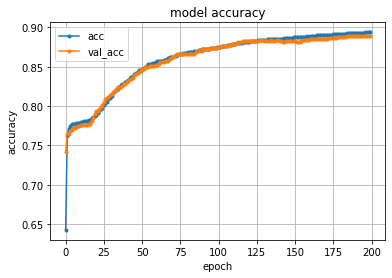

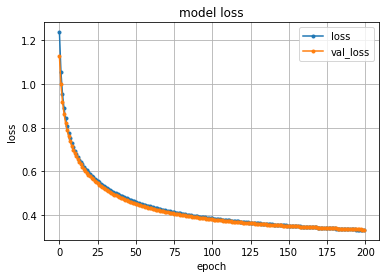

In [39]:
import matplotlib.pyplot as plt

# 精度のplot
plt.plot(history.history['accuracy'], marker='.', label='acc')
plt.plot(history.history['val_accuracy'], marker='.', label='val_acc')
plt.title('model accuracy')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

# 損失のplot
plt.plot(history.history['loss'], marker='.', label='loss')
plt.plot(history.history['val_loss'], marker='.', label='val_loss')
plt.title('model loss')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

In [40]:
model = NN(4)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=loss,
              metrics=['accuracy']
             )

In [41]:
epochs = 500

In [42]:
tb_cb = tf.keras.callbacks.TensorBoard(
    log_dir='./log/',
    histogram_freq=1,
    write_images=True
)

In [43]:
%reload_ext tensorboard
%tensorboard --logdir log --bind_all --port 6006 --reload_multifile true

In [44]:
history = model.fit(train_v,train_t,
                    epochs=epochs, 
                    validation_data=(valid_v, valid_t),
                    verbose=0,
                    callbacks=[tb_cb]
                   )